# Capstone Project - Journal of Emotion

- __Student name: Chamila Dharmawardhana__  
- __Student pace: Full time__  
- __Scheduled project review date: July 28, 2020__  
- __Instructor name: Amber Yandow__


Objective: 
- build a CNN with various sources of data to detect emotion of a give facial image
- The baseline model is built with the dataset for kaggel competition "Facial Emotion Recognition" 
- evaluate the base model 
- Optimize the base model so that overfitting or underfitting is reduced as much as possible. 
- Evaluate the tuned model 
- demonstrate the accuracy of the latter model with new images

__connect to google drive to work in colab__

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
path='drive/My Drive/Facial-Expression-Detection-V2'
print(os.listdir(path))

['3.jpg', 'face_crop.py', '2.jpg', '.gitignore', 'LICENSE', '1.jpg', 'haarcascade_frontalface_alt.xml', 'README.md', '.ipynb_checkpoints', 'data', 'fer2013', '.git', 'FED_FIW_local_test.ipynb', 'FED.ipynb', 'FED_transfer_local.ipynb', 'FED_transfer.ipynb', 'photo.jpg', 'capture.jpg', 'backup', 'models', 'FED_regularize.ipynb']


In [3]:
# Load essential libraries
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data handling. 

Here ConfigProto will request number of CPU/GPU nodes needed for the calculation and setup tensorflow for parallel calculations

- upload data from fer2013.csv and seperate it to training and testing dataframes
- set number of classes (7 in this case)
- show total number of datapoints and testing:training split

The both training and evaluation operations would be handled with [kaggel FER2013](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) dataset + faces from the wild (scraped from google images). fer2013.csv already contain tags 'Training' and 'PublicTest' to seperate the data. It's set to 80:20 split, which is a good value for a CNN project. 

In [4]:
#------------------------------
#cpu - gpu configuration
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 8 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
#sess = tf.Session(config=config) 
#keras.backend.set_session(config)

#------------------------------
#read kaggle facial expression recognition challenge dataset (fer2013.csv)

with open(path+"/data/fer2013.csv") as f:
  content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []
num_classes = 7                           #angry, disgust, fear, happy, sad, surprise, neutral

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
      print("", end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#------------------------------

number of instances:  35888
instance length:  2304
28709 train samples
3589 test samples


# base model

Here I build a sensible CNN that may be adecuate as the baseline model. Then the resultant model is saved to the disk. 

In [5]:
#------------------------------
#variables
batch_size = 256
epochs = 25
#------------------------------

#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(32, (1, 1), strides=1, padding='same', input_shape=(48, 48, 1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#2nd convolution layer
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#3rd convolution layer
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))
#------------------------------
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
test_generator = gen.flow(x_test, y_test, batch_size=batch_size)


#------------------------------

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'] )

#------------------------------

fit = False

if fit == False:
    #model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
    history = model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs, 
                                  validation_data=test_generator) #train for randomly selected one
    model.save(path+'/models/model_base.h5')
else:
    model = load_model(path+'/models/model_base.h5')
 

Epoch 1/25
256/256 [==============================] - 13s 51ms/step - loss: 1.6755 - accuracy: 0.3272 - val_loss: 1.1635 - val_accuracy: 0.4285
Epoch 2/25
256/256 [==============================] - 6s 25ms/step - loss: 1.3762 - accuracy: 0.4719 - val_loss: 1.4025 - val_accuracy: 0.4826
Epoch 3/25
256/256 [==============================] - 7s 25ms/step - loss: 1.1793 - accuracy: 0.5554 - val_loss: 1.2670 - val_accuracy: 0.5233
Epoch 4/25
256/256 [==============================] - 6s 25ms/step - loss: 0.9822 - accuracy: 0.6342 - val_loss: 0.8637 - val_accuracy: 0.5308
Epoch 5/25
256/256 [==============================] - 7s 25ms/step - loss: 0.7221 - accuracy: 0.7334 - val_loss: 1.8786 - val_accuracy: 0.5528
Epoch 6/25
256/256 [==============================] - 6s 25ms/step - loss: 0.5052 - accuracy: 0.8191 - val_loss: 1.0405 - val_accuracy: 0.5430
Epoch 7/25
256/256 [==============================] - 7s 25ms/step - loss: 0.3471 - accuracy: 0.8773 - val_loss: 1.1823 - val_accuracy: 0.543

The baseline model clearly suffers from __overfitting__. Therefore, we must tune the hyperparameters to reduce the variance of the model and get the training and validation accuracy closer. The CNN models for facial recognition generally suffers from low accuracy as the labels are inherantly linearly dependant. Thus, various degree of regularization. After many trials following set of parameters were chose to provide the best results. 

In [47]:
from keras import regularizers
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
epochs = 100
l2_num = 0.001

#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (5, 5), strides=1, padding='same', input_shape=(48, 48, 1) , kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
#model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(2048, kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(l2_num)))
model.add(Activation('softmax'))

#------------------------------
#batch process
gen = ImageDataGenerator(zoom_range=0.3)
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
test_generator = gen.flow(x_test, y_test, batch_size=batch_size)


model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'] )
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
#------------------------------

fit = False

if fit == False:
    #model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
    history = model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs, 
                                  validation_data=test_generator) #train for randomly selected one
    model.save(path+'/models/model_reg.h5')
else:
    model = load_model(path+'/models/model_reg.h5') #load weights


Epoch 1/100
256/256 [==============================] - 19s 75ms/step - loss: 2.4843 - accuracy: 0.3447 - val_loss: 2.7286 - val_accuracy: 0.2382
Epoch 2/100
256/256 [==============================] - 18s 72ms/step - loss: 1.6166 - accuracy: 0.4492 - val_loss: 2.0796 - val_accuracy: 0.4121
Epoch 3/100
256/256 [==============================] - 19s 73ms/step - loss: 1.5364 - accuracy: 0.4915 - val_loss: 1.9721 - val_accuracy: 0.4990
Epoch 4/100
256/256 [==============================] - 19s 73ms/step - loss: 1.5037 - accuracy: 0.5119 - val_loss: 1.1317 - val_accuracy: 0.4996
Epoch 5/100
256/256 [==============================] - 18s 72ms/step - loss: 1.4842 - accuracy: 0.5287 - val_loss: 1.4284 - val_accuracy: 0.5177
Epoch 6/100
256/256 [==============================] - 18s 72ms/step - loss: 1.4625 - accuracy: 0.5393 - val_loss: 1.8948 - val_accuracy: 0.5277
Epoch 7/100
256/256 [==============================] - 19s 72ms/step - loss: 1.4425 - accuracy: 0.5511 - val_loss: 1.6937 - val_ac

## **evaluate the  improved Model**

In [48]:
#Evaluation
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 1.062768704855744
Train accuracy: 76.53000950813293
Test loss: 1.5189050537990507
Test accuracy: 60.7968807220459


Following funtiction builds a barchart for a given mages emotion analysis

In [49]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

Let's visualize 10 sample pictures and their predictions for the test dataset. 

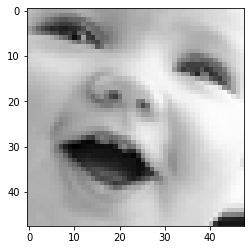

[0.01272661 0.00088982 0.02702023 0.8340592  0.02093263 0.07738394
 0.02698759]


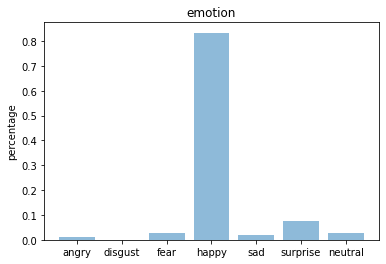

----------------------------------------------


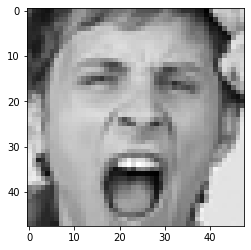

[7.0673651e-01 1.3588108e-04 2.8810820e-01 7.8735070e-04 2.8809116e-03
 1.2940608e-03 5.7164198e-05]


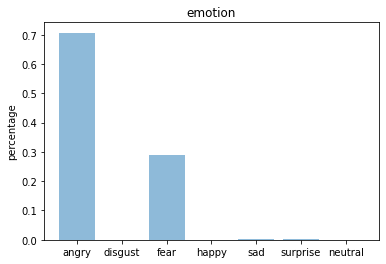

----------------------------------------------


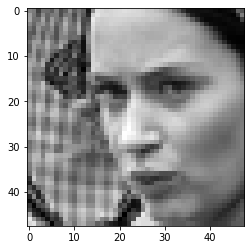

[0.39907786 0.00265778 0.198809   0.00589096 0.27238318 0.00487461
 0.11630665]


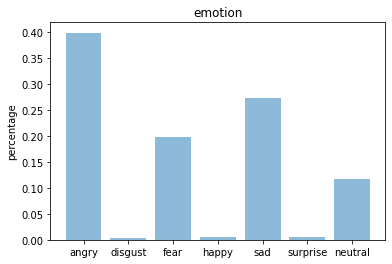

----------------------------------------------


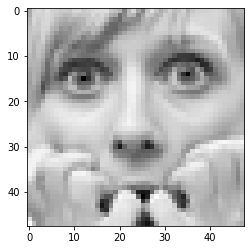

[2.9205030e-02 2.5142395e-04 4.5385170e-01 3.1188566e-03 4.2001940e-03
 5.0853187e-01 8.4093242e-04]


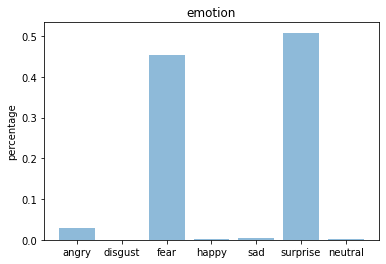

----------------------------------------------


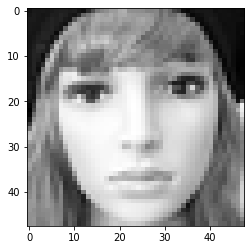

[3.6654931e-02 3.4326495e-04 1.0727162e-01 2.7328255e-03 3.9817801e-01
 3.0774577e-03 4.5174181e-01]


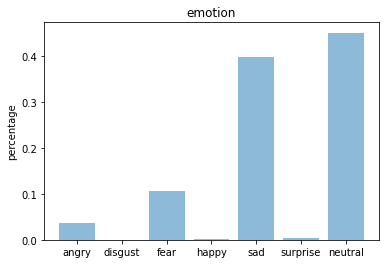

----------------------------------------------


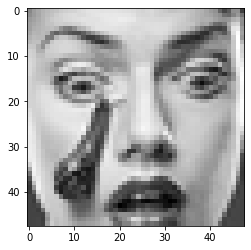

[0.07899257 0.00137319 0.27026698 0.0063183  0.00464951 0.63690114
 0.00149829]


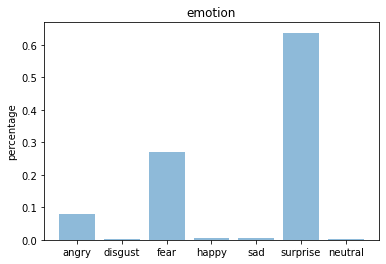

----------------------------------------------


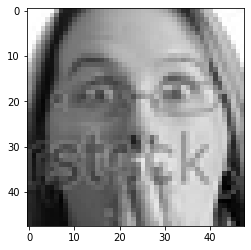

[2.3671519e-03 2.8337352e-05 3.0787218e-01 2.7018376e-03 1.8002117e-03
 6.8466461e-01 5.6575128e-04]


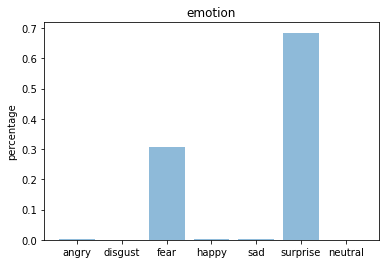

----------------------------------------------


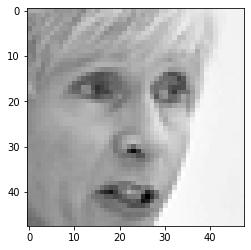

[1.4247283e-02 3.9319257e-04 1.5571773e-01 3.5337317e-03 1.6287893e-02
 7.9788655e-01 1.1933627e-02]


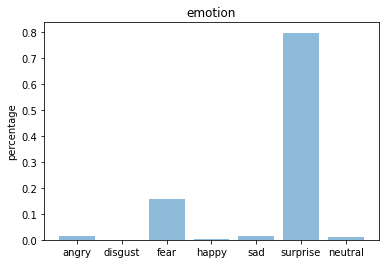

----------------------------------------------


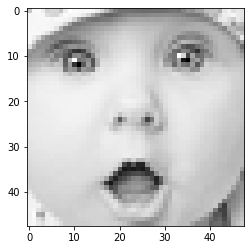

[4.3606592e-04 2.8756604e-06 3.7469696e-02 3.8089009e-04 5.4661545e-04
 9.5978171e-01 1.3822924e-03]


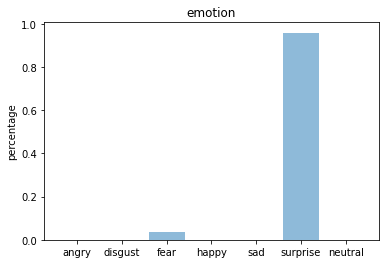

----------------------------------------------


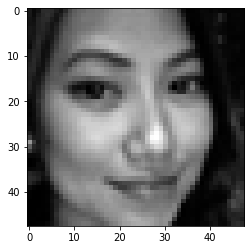

[3.3306493e-04 6.5632426e-06 7.4281549e-04 8.1617236e-01 2.9370743e-03
 4.2086919e-03 1.7559943e-01]


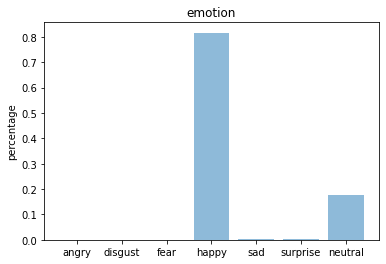

----------------------------------------------


In [50]:
monitor_testset_results = True

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 20 and index >= 10:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

Visual inspection of the results show most picture and predictions looks to be correct. Thus even with the modest accuracy the model does well. 

In [51]:
#Confusion Matrix.

from sklearn.metrics import classification_report, confusion_matrix
 
pred_list = []; actual_list = []
 
for i in predictions: 
    pred_list.append(np.argmax(i))


for i in y_test: 
    actual_list.append(np.argmax(i))


cm = confusion_matrix(actual_list, pred_list)
cm

array([[233,   1,  36,  34,  65,  21,  77],
       [  9,  27,   3,   2,   9,   1,   5],
       [ 50,   1, 154,  33, 105,  70,  83],
       [ 28,   0,  19, 716,  29,  26,  77],
       [ 75,   0,  56,  52, 296,  27, 147],
       [  8,   0,  19,  15,  13, 346,  14],
       [ 27,   1,  26,  57,  76,  10, 410]])

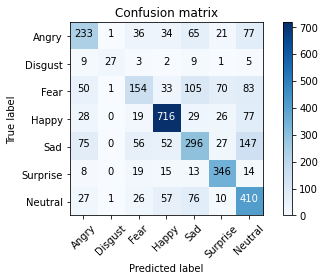

In [52]:
import itertools
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Confusion matrix looks good considering the accuracy of the model. 

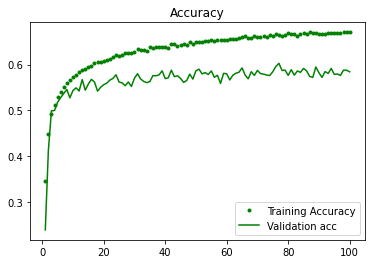

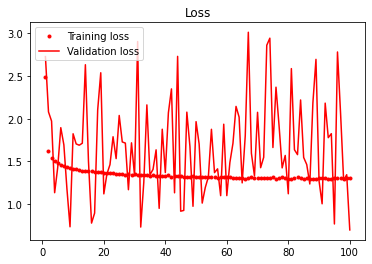

In [53]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

It is observed that after about 100 iterations the training and validation accuracies converg. To increase the accuracy further more and high quality images must be obtained. 

following function can be used to obtain the prediction for any given picture. This function can be usen in the journal app for predictions. 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


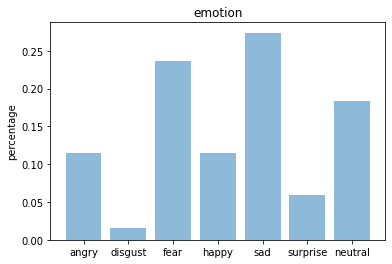

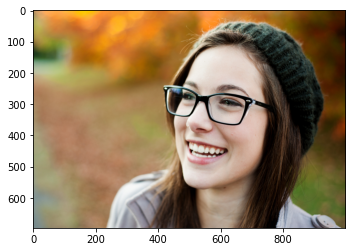

In [67]:
#Testing a file.

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

def plotface(file):
    #file = path+'/1.jpg'
    true_image = image.load_img(file)
    img = image.load_img(file, grayscale=True, target_size=(48, 48))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)
    emotion_analysis(custom[0])

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(true_image)
    plt.show()

plotface(path+'/1.jpg')

As shown above the prediction for the given image is not that good. Thus to further improve the predictions we must crop the face from the image so the background is ignored when predicting emotion. Following functino uses the HAAR cascade pre-trained model provided by opneCV to detect and crop a face from an image. 

Writing: drive/My Drive/Facial-Expression-Detection-V2/1.jpg


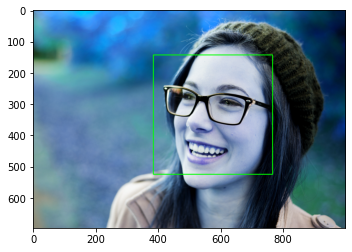

In [68]:
import cv2

def facecrop(image):  
    """
    Use pretrained HAAR cascade to detect the face and build a bounding box 
    """
    facedata = '/content/drive/My Drive/Facial-Expression-Detection-V2/haarcascade_frontalface_alt.xml'
    #facedata = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            
            cv2.imwrite(path+'/capture.jpg', sub_face)
            print ("Writing: " + image)

    except Exception as e:
        print (e)

    #cv2.imshow(image, img)
    plt.imshow(img)


facecrop(path+'/1.jpg')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


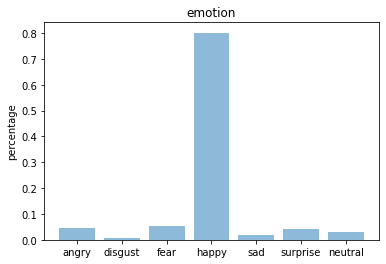

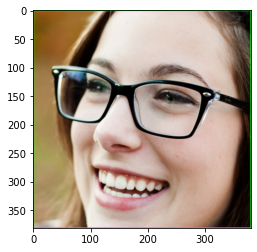

In [69]:
plotface(path+'/capture.jpg')

As we observe the predictions for the croped image is much better. Thus this fuction can be used in the journal app to crop the face from an image before it is fed to the model. 

Following function is taken from google.colab to enable webcan within the colab notebook. This allows to take a picture directly from the webcam, save it to the disk and make predictions by calling facecrop() and plotface() functions. 

In [70]:
#CODE for Capturing an image on Colab from here: https://colab.research.google.com/notebook#fileId=1OnUy6eFE7XhdfGfAHDCqQxpwueTOj_NO

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename=path+'/photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [71]:
take_photo()

<IPython.core.display.Javascript object>

'drive/My Drive/Facial-Expression-Detection-V2/photo.jpg'

Writing: drive/My Drive/Facial-Expression-Detection-V2/photo.jpg


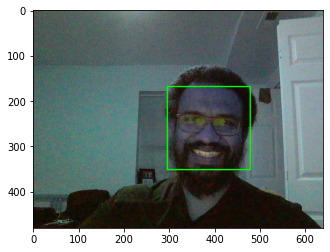

In [72]:
#Test the captured image
facecrop(path+'/photo.jpg')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


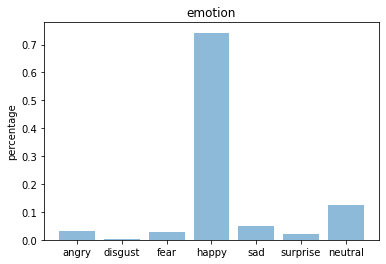

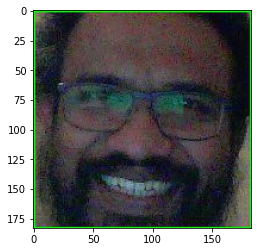

In [73]:
plotface(path+'/capture.jpg')

## conclusion

- from fer2013 dataset a reasonable accuracy can be acieved. 
- croping faces from images are essential to identify emotinos.
- This should be a good starting model for the journal app.